In [41]:
import numpy as np
import matplotlib.pyplot as plt
import os, signal
import cv2
import seaborn as sns
import pandas as pd
import pickle
import time

from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,load_model, model_from_yaml
from tensorflow.keras.layers import Dense,Flatten,GlobalAveragePooling2D
from tensorflow.keras import models,Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

In [2]:
DATA_DIR='C:\g_images\downloads\originals'
CLASSES = ['cats','dogs','panda','bikes','horse']

In [ ]:
training_data=[] #list
training_label=[]
training_data_raw=[] #list

img_resize = 224

def self_generated_train_data():
    for c in CLASSES:
        path = os.path.join(DATA_DIR,c)
        class_no = CLASSES.index(c)
        for img in os.listdir(path):
            #print(os.path.join(path,img))
            img_array_bgr = cv2.imread(os.path.join(path,img))
            rgb_img = cv2.cvtColor(img_array_bgr, cv2.COLOR_BGR2RGB)
            rgb_image_resized = cv2.resize(rgb_img,(img_resize,img_resize)) #cv2.resize() follows (width,height) unlike as expected (height, width)
            training_data.append(rgb_image_resized) #append array to a list
            training_label.append(class_no)
            training_data_raw.append(rgb_img) 
                        
        print("Class %d loaded: %s "%(class_no,c))

In [ ]:
self_generated_train_data()

In [ ]:
# save the resized data to prevent from re-loading

pickle_out=open("training_data_224px_VGG16.pickle",'wb')
pickle.dump(training_data,pickle_out)
pickle_out.close()

pickle_out=open("training_label_224px_VGG16.pickle",'wb')
pickle.dump(training_label,pickle_out)
pickle_out.close()

pickle_out=open("training_data_224px_VGG16_raw.pickle",'wb')
pickle.dump(training_data_raw,pickle_out)
pickle_out.close()

In [3]:
# to load the resized data
pickle_in = open("training_data_224px_VGG16.pickle",'rb')
training_data = pickle.load(pickle_in)

pickle_in = open("training_label_224px_VGG16.pickle",'rb')
training_label = pickle.load(pickle_in)

pickle_in = open("training_data_224px_VGG16_raw.pickle",'rb')
training_data_raw = pickle.load(pickle_in)

In [4]:
# Convert into an array for model input
training_data = np.array(training_data)
training_label = np.array(training_label)

In [5]:
print("Training data shape:",training_data.shape)
print("Training label shape:",training_label.shape)

Training data shape: (2750, 224, 224, 3)
Training label shape: (2750,)


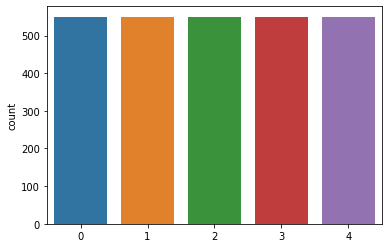

In [6]:
sns.countplot(training_label)

In [7]:
Class_label_counters = {label:list(training_label).count(label) for label in list(training_label)}
print('Class counts:',Class_label_counters)

Class counts: {0: 550, 1: 550, 2: 550, 3: 550, 4: 550}


In [8]:
total_classes = len(np.unique(training_label))
print('Total Number of classes:',total_classes)

Total Number of classes: 5


In [9]:
y_categorical = to_categorical(training_label,total_classes)

In [10]:
# Normalize the data 
training_data = training_data.astype('float32') / 255.

In [11]:
#shuffle the dataset
x_shuffle,y_shuffle = shuffle(training_data,y_categorical,random_state=15)
x_shuffle_raw,_ = shuffle(training_data_raw,y_categorical,random_state=15)

In [12]:
# test data split
X, X_test, Y, Y_test = train_test_split(x_shuffle,y_shuffle,test_size = 0.10,random_state=16)
_, X_test_raw, _, _ = train_test_split(x_shuffle_raw,y_shuffle,test_size = 0.10,random_state=16)

In [13]:
# train and valid data split
X_train,X_valid,Y_train,Y_valid = train_test_split(X,Y,test_size = 0.20)

In [14]:
print("Test data shape after split:",X_test.shape)

Test data shape after split: (275, 224, 224, 3)


In [15]:
print("Training data shape after split:",X_train.shape)
print("Validation data shape after split:",X_valid.shape)

Training data shape after split: (1980, 224, 224, 3)
Validation data shape after split: (495, 224, 224, 3)


In [16]:
print("Training label shape after split:",Y_train.shape)
print("Validation label shape after split:",Y_valid.shape)

Training label shape after split: (1980, 5)
Validation label shape after split: (495, 5)


#### Using Pretrained Model VGG16

In [17]:
modelVGG = VGG16(weights ='imagenet',include_top = True)
modelVGG.summary()

W0909 00:15:08.384948 13456 deprecation.py:506] From C:\ProgramData\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [18]:
CNN_VGG = Model(inputs = modelVGG.input,outputs = modelVGG.layers[-6].output)
CNN_VGG.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
# create new model
gap_NN = Sequential()
gap_NN.add(GlobalAveragePooling2D())
gap_NN.add(Dense(5,activation = 'softmax'))

In [20]:
# this way only save the weights not the architecture, we have to recreate the same architecture to load the saved weights
full_model = Model(inputs = CNN_VGG.input, 
                   outputs = gap_NN(CNN_VGG.output))
full_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# or in another way, it will save weights and architecture

# last_conv_layer = modelVGG.get_layer('block5_conv3').output # modelVGG.layers[-6].output
# gap_layer = GlobalAveragePooling2D()(last_conv_layer)
# classification_layer = Dense(5,activation = 'softmax')(gap_layer)

# full_model = Model(inputs = modelVGG.input, 
#                    outputs = classification_layer)

# full_model.summary()


In [21]:
for layer in full_model.layers[:-1]:
    layer.trainable = False

In [22]:
for layer in full_model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000021903A9A978> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000021903A9A5F8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000021939211CF8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000021903AFF9E8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000021903EB82B0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000021903ED94E0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000021903EE60F0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000021904ACDF60> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000021904AE9BE0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000021904B03278> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000021904B357B8> False
<tensorflow.python.

In [23]:
full_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [24]:
#full_model.summary()

In [25]:
early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0.001,
                                       patience=10,
                                       verbose=1, 
                                       mode='min',
                                       restore_best_weights=True)

In [26]:
model_checkpoint = ModelCheckpoint('VGG16_CAM_mc.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [27]:
reduce_LR_OnPlateau = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.1,
                                        patience=5)

In [28]:
# train the network
history = full_model.fit(X_train, Y_train, 
                    epochs=70, 
                    batch_size=15,
                    validation_data = (X_valid,Y_valid),
                    callbacks=[early_stopping,model_checkpoint,reduce_LR_OnPlateau])

Train on 1980 samples, validate on 495 samples
Epoch 1/70
1965/1980 [============================>.] - ETA: 0s - loss: 1.3592 - acc: 0.5282
Epoch 00001: val_acc improved from -inf to 0.73939, saving model to VGG16_CAM_mc.h5
1980/1980 [==============================] - 137s 69ms/sample - loss: 1.3582 - acc: 0.5298 - val_loss: 1.1305 - val_acc: 0.7394
Epoch 2/70
1965/1980 [============================>.] - ETA: 0s - loss: 0.9850 - acc: 0.8137
Epoch 00002: val_acc improved from 0.73939 to 0.83636, saving model to VGG16_CAM_mc.h5
1980/1980 [==============================] - 124s 63ms/sample - loss: 0.9840 - acc: 0.8131 - val_loss: 0.8910 - val_acc: 0.8364
Epoch 3/70
1965/1980 [============================>.] - ETA: 0s - loss: 0.8032 - acc: 0.8478
Epoch 00003: val_acc improved from 0.83636 to 0.86667, saving model to VGG16_CAM_mc.h5
1980/1980 [==============================] - 97s 49ms/sample - loss: 0.8031 - acc: 0.8485 - val_loss: 0.7525 - val_acc: 0.8667
Epoch 4/70
1965/1980 [===========

1965/1980 [============================>.] - ETA: 0s - loss: 0.2204 - acc: 0.9450
Epoch 00029: val_acc did not improve from 0.93737
1980/1980 [==============================] - 104s 53ms/sample - loss: 0.2203 - acc: 0.9455 - val_loss: 0.2513 - val_acc: 0.9333
Epoch 30/70
1965/1980 [============================>.] - ETA: 0s - loss: 0.2159 - acc: 0.9496
Epoch 00030: val_acc improved from 0.93737 to 0.94141, saving model to VGG16_CAM_mc.h5
1980/1980 [==============================] - 105s 53ms/sample - loss: 0.2154 - acc: 0.9500 - val_loss: 0.2484 - val_acc: 0.9414
Epoch 31/70
1965/1980 [============================>.] - ETA: 0s - loss: 0.2109 - acc: 0.9476
Epoch 00031: val_acc did not improve from 0.94141
1980/1980 [==============================] - 104s 52ms/sample - loss: 0.2119 - acc: 0.9475 - val_loss: 0.2434 - val_acc: 0.9333
Epoch 32/70
1965/1980 [============================>.] - ETA: 0s - loss: 0.2088 - acc: 0.9501
Epoch 00032: val_acc did not improve from 0.94141
1980/1980 [====

Epoch 59/70
1965/1980 [============================>.] - ETA: 0s - loss: 0.1351 - acc: 0.9674
Epoch 00059: val_acc did not improve from 0.95354
1980/1980 [==============================] - 103s 52ms/sample - loss: 0.1357 - acc: 0.9672 - val_loss: 0.1886 - val_acc: 0.9475
Epoch 60/70
1965/1980 [============================>.] - ETA: 0s - loss: 0.1337 - acc: 0.9628
Epoch 00060: val_acc did not improve from 0.95354
1980/1980 [==============================] - 103s 52ms/sample - loss: 0.1340 - acc: 0.9626 - val_loss: 0.1859 - val_acc: 0.9495
Epoch 61/70
1965/1980 [============================>.] - ETA: 0s - loss: 0.1323 - acc: 0.9674
Epoch 00061: val_acc did not improve from 0.95354
1980/1980 [==============================] - 104s 53ms/sample - loss: 0.1329 - acc: 0.9677 - val_loss: 0.1857 - val_acc: 0.9495
Epoch 62/70
1965/1980 [============================>.] - ETA: 0s - loss: 0.1309 - acc: 0.9659
Epoch 00062: val_acc did not improve from 0.95354
1980/1980 [=============================

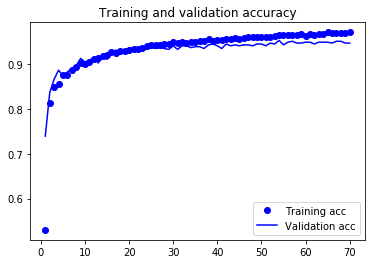

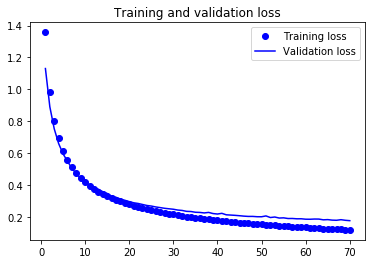

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [30]:
full_model.save('camTL.h5')

In [31]:
#full_model.load_weights('camTL.h5')

In [32]:
full_model.evaluate(X_test,Y_test,batch_size=1)

275/275 [==============================] - 60s 217ms/sample - loss: 0.1583 - acc: 0.9491


[0.1582523331380874, 0.9490909]

In [33]:
classifier_weights = full_model.layers[-1].get_weights()[0] #last layer weights

In [34]:
print('Shape of Weight: ',classifier_weights.shape)

Shape of Weight:  (512, 5)


In [35]:
# create new model that will return two output
cam_model2 = Model(inputs=full_model.input,
                  outputs=(full_model.layers[-2].output, full_model.layers[-1].output))

In [36]:
Activation_maps, Predict_prob = cam_model2.predict(X_test,batch_size=1)

In [37]:
Activation_maps.shape, Predict_prob.shape

((275, 14, 14, 512), (275, 5))

In [39]:
def cam_plot(datasetSize = X_test,dataset_2 = X_test_raw, plotting = True):

    num_images = 10

    random_test_image_ind = np.random.randint(datasetSize.shape[0], size=num_images)
    
    if plotting:
            plt.figure(figsize=(20, 6))

    for i,image_index in enumerate(random_test_image_ind):

        Activation_map_for_one_img = Activation_maps[image_index, :, :, :]

        pred_id = np.argmax(Predict_prob[image_index])

        predicted_class_weights = classifier_weights[:,pred_id]

        cam = np.zeros(dtype = np.float32, shape = Activation_map_for_one_img.shape[0:2])

        for j, w in enumerate(predicted_class_weights):

            cam += np.dot(w, Activation_map_for_one_img[:, :, j])

        cam/=np.max(cam)

        cam = cv2.resize(cam, (X_test_raw[image_index].shape[1], X_test_raw[image_index].shape[0]))

        heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)

        heatmap = np.maximum(heatmap,0)
        heatmap[np.where(cam<0.2)]=0

        superimposed_img = heatmap*0.5 + (X_test_raw[image_index])

        if plotting:
            
            ax = plt.subplot(2, num_images/2, i+1)
            plt.imshow(np.uint8(superimposed_img))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
        fn = 'image_'+str(image_index)+'.jpg'
        cv2.imwrite(fn, (superimposed_img))

In [42]:
start_time = time.time()
for i in range(100):
    cam_plot(dataset_2=X_test_raw,plotting=False)
print("--- %s seconds ---" % (time.time() - start_time))

--- 377.281729221344 seconds ---


In [ ]:
# if functional module is followed by sequential module 
# then trying to save the model only allow to store the weights not the architecture.

# better to write the code in funtional followed by functional